Suppose

* $K(x,x') = \exp(-\frac{\|x-x'\|^2}{2\ell^2})$ with $\ell=0.5$ (RBF with lengthscale 0.5)
* Independent noises
    * $\epsilon_1\sim N(0, \sigma^2 = 0.09)$
    * $\epsilon_2 \sim N(0, \sigma^2 = 0.01)$
* $f$ is mean zero GP with kernel $K$
* $y_1 = 2 f(x) + \epsilon_1$
* $y_2 = -0.5 f(x) + \epsilon_2$

Generate 100 observations of $(x, y_1, y_2)$ according to $x \in\{ 0.01, 0.02, 0.03, \cdots 1\}$ using ``sklearn``, then try to recover parameters with ``gpytorch``

In [1]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

import numpy as np
import matplotlib.pyplot as plt

import math
import torch
import gpytorch


In [2]:
l = 0.5
sigma1 = 0.3
sigma2 = 0.1
n = 100

X = np.linspace(0.01, 1, 100).reshape(-1,1)

K = RBF(length_scale=l)

f = GaussianProcessRegressor(kernel=K)
f_obs = f.sample_y(X, n_samples=1, random_state=1234)
f_obs = f_obs[:,0]

# generate noise

np.random.seed(12345)

y1 = 2 * f_obs + np.random.normal(scale=sigma1, size=100)
y2 = -0.5 * f_obs + np.random.normal(scale=sigma2, size=100)


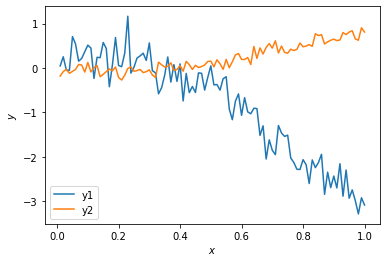

In [3]:
plt.plot(X, y1, label="y1")
plt.plot(X, y2, label="y2")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [4]:
train_x = torch.from_numpy(X).float()
train_y = torch.stack([
    torch.from_numpy(y1).float(),
    torch.from_numpy(y2).float(),
])

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [5]:
training_iterations = 200

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/200 - Loss: 1.398
Iter 2/200 - Loss: 1.369
Iter 3/200 - Loss: 1.338
Iter 4/200 - Loss: 1.302
Iter 5/200 - Loss: 1.264
Iter 6/200 - Loss: 1.226
Iter 7/200 - Loss: 1.188
Iter 8/200 - Loss: 1.151
Iter 9/200 - Loss: 1.116
Iter 10/200 - Loss: 1.083
Iter 11/200 - Loss: 1.050
Iter 12/200 - Loss: 1.016
Iter 13/200 - Loss: 0.978
Iter 14/200 - Loss: 0.939
Iter 15/200 - Loss: 0.901
Iter 16/200 - Loss: 0.865
Iter 17/200 - Loss: 0.829
Iter 18/200 - Loss: 0.796
Iter 19/200 - Loss: 0.765
Iter 20/200 - Loss: 0.736
Iter 21/200 - Loss: 0.711
Iter 22/200 - Loss: 0.692
Iter 23/200 - Loss: 0.677
Iter 24/200 - Loss: 0.662
Iter 25/200 - Loss: 0.648
Iter 26/200 - Loss: 0.633
Iter 27/200 - Loss: 0.619
Iter 28/200 - Loss: 0.608
Iter 29/200 - Loss: 0.601
Iter 30/200 - Loss: 0.595
Iter 31/200 - Loss: 0.591
Iter 32/200 - Loss: 0.587
Iter 33/200 - Loss: 0.584
Iter 34/200 - Loss: 0.581
Iter 35/200 - Loss: 0.578
Iter 36/200 - Loss: 0.575
Iter 37/200 - Loss: 0.571
Iter 38/200 - Loss: 0.566
Iter 39/200 - Loss: 0

``model.state_dict()`` returns nonsensical values since they're on log scale:

In [6]:
model.state_dict()

OrderedDict([('likelihood.raw_task_noises', tensor([-3.3837, -3.5331])),
             ('likelihood.raw_noise', tensor([-3.4435])),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf)),
             ('likelihood.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_noise_constraint.upper_bound', tensor(inf)),
             ('covar_module.task_covar_module.covar_factor',
              tensor([[-0.8417],
                      [-0.8321]])),
             ('covar_module.task_covar_module.raw_var',
              tensor([-6.4903, -6.7582])),
             ('covar_module.task_covar_module.raw_var_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.task_covar_module.raw_var_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.data_covar_module.raw_lengthsca

In [7]:
model.covar_module.task_covar_module.covar_matrix.evaluate()

tensor([[0.7099, 0.7003],
        [0.7003, 0.6935]], grad_fn=<AddBackward0>)

In [8]:
print(model.covar_module.task_covar_module.raw_var)
print(torch.exp(model.covar_module.task_covar_module.raw_var))

Parameter containing:
tensor([-6.4903, -6.7582], requires_grad=True)
tensor([0.0015, 0.0012], grad_fn=<ExpBackward0>)


In [10]:
print(model.covar_module.data_covar_module.raw_lengthscale)
print(torch.exp(model.covar_module.data_covar_module.raw_lengthscale))

Parameter containing:
tensor([[-3.7403]], requires_grad=True)
tensor([[0.0237]], grad_fn=<ExpBackward0>)
